# Two task network 

## Network has some inputs

1. The fixation. 
1. The first context mod. 
1. The second ontext mod. 

## Network has five outputs
1. The fixation. 
1. The first output.
1. The second output




<div>
<img src="./images/Sheme.png" width="300"/>
</div>

> Learning rule: superspike

> Neuron type: Lif + refrac

> Task: romo


In [1]:
import torch
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt  # for analys
from cgtasknet.net.lifadexrefrac import SNNlifadexrefrac
from cgtasknet.tasks.reduce import RomoTask, DefaultParams
from norse.torch.functional.lif_adex_refrac import LIFAdExRefracParameters
from norse.torch.functional.lif_adex import LIFAdExParameters

# from norse.torch import LIF

## Step -1: Create dataset

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = torch.device('cpu')
print(f'Device: {("gpu (cuda)" if device.type=="cuda" else "cpu")}')

Device: gpu (cuda)


In [3]:
batch_size = 50
number_of_tasks = 2
task_parameters = DefaultParams("RomoTask").generate_params()
task_parameters["delay"] = 0.1
task_parameters["trial_time"] = 0.1
Task = RomoTask(params=task_parameters, batch_size=batch_size)
Task_test = RomoTask(params=task_parameters, batch_size=1)
print("Task params:")
for key in task_parameters:
    if key != "values":
        print(
            f"{key}".center(10, "."),
            f'value: {int((task_parameters[key] / task_parameters["dt"]))}ms',
        )

Task params:
....dt.... value: 1ms
..delay... value: 100ms
trial_time value: 100ms


## Step 1.1: Create model

In [4]:
feature_size, output_size = Task.feature_and_act_size
hidden_size = 250

neuron_parameters = LIFAdExRefracParameters(
    LIFAdExParameters(
        v_th=torch.as_tensor(0.65).to(device),
        tau_ada_inv=torch.as_tensor(1).to(device),
    ),
    rho_reset=torch.as_tensor(0.5).to(device),
)
model = SNNlifadexrefrac(
    feature_size,
    hidden_size,
    output_size,
    neuron_parameters=neuron_parameters,
    tau_filter_inv=500,
).to(device)

## Step 1.2: Save pre-learning weights

In [5]:
weights_pre_l = []
with torch.no_grad():
    for name, param in model.named_parameters():
        if param.requires_grad:
            weights_pre_l.append((param).cpu().numpy())

## Step 2: loss and creterion 

In [6]:
learning_rate = 1e-3


class RMSELoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.mse = nn.MSELoss()

    def forward(self, yhat, y):
        return torch.sqrt(self.mse(yhat, y))


criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
# optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

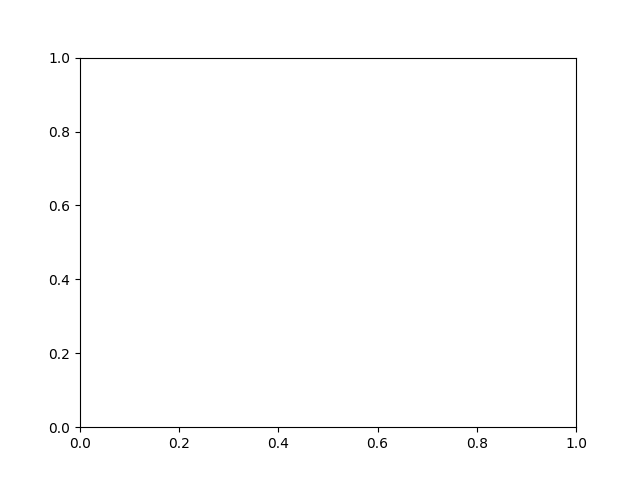

In [7]:
%matplotlib widget
plt.ion

fig = plt.figure()
ax = fig.add_subplot(111)

## Step 3: Train loop

In [8]:
from cgtasknet.net.states import LIFAdExRefracInitState

init_state = LIFAdExRefracInitState(batch_size, hidden_size, device=device)

ax.set_title("lif adex refrac")
inputs, target_outputs = Task.dataset(number_of_tasks)
running_loss = 0
fig.canvas.draw()
fig.canvas.flush_events()
for i in range(4000):
    dmparams1 = DefaultParams("RomoTask").generate_params()

    dmparams1["delay"] = np.random.uniform(0.01, 0.2)
    dmparams1["trial_time"] = np.random.uniform(0.1, 0.25)
    Task.params = dmparams1
    inputs, target_outputs = Task.dataset(number_of_tasks, delay_between=200)
    inputs += np.random.normal(0, 0.01, size=(inputs.shape))
    inputs = torch.from_numpy(inputs).type(torch.float).to(device)
    target_outputs = torch.from_numpy(target_outputs).type(torch.float).to(device)
    optimizer.zero_grad()

    # forward + backward + optimize
    outputs, states = model(inputs, state=init_state.random_state())

    loss = criterion(outputs, target_outputs)
    loss.backward()
    optimizer.step()

    # print statistics
    running_loss += loss.item()
    if i % 10 == 9:
        print("epoch: {:d} loss: {:0.5f}".format(i + 1, running_loss / 10))
        running_loss = 0.0
        with torch.no_grad():
            Task_test.params = dmparams1
            inputs, target_outputs = Task_test.dataset(
                number_of_tasks, delay_between=200
            )

            inputs = torch.from_numpy(inputs).type(torch.float).to(device)
            target_outputs = (
                torch.from_numpy(target_outputs).type(torch.float).to(device)
            )
            outputs, states = model(inputs)
            loss = criterion(outputs, target_outputs)
            torch.save(
                model.state_dict(),
                "Only_romo_lif_adex_refrac_net_random_two_trials_250",
            )
            print("test loss: {:0.5f}".format(loss.item()))
        for_plot = outputs.detach().cpu().numpy()[:, 0, :]
        ax.clear()
        ax.plot(for_plot[:, 1], c="r")
        ax.plot(for_plot[:, 2], c="b")
        ax.plot(target_outputs.detach().cpu().numpy()[:, 0, 1], c="r")
        ax.plot(target_outputs.detach().cpu().numpy()[:, 0, 2], c="b")

    fig.canvas.draw()
    fig.canvas.flush_events()
print("Finished Training")

epoch: 10 loss: 0.27805
test loss: 0.27489
epoch: 20 loss: 0.24052
test loss: 0.19130
epoch: 30 loss: 0.15889
test loss: 0.11896
epoch: 40 loss: 0.09215
test loss: 0.06226
epoch: 50 loss: 0.06355
test loss: 0.04545
epoch: 60 loss: 0.05214
test loss: 0.04552
epoch: 70 loss: 0.04902
test loss: 0.05177
epoch: 80 loss: 0.04281
test loss: 0.04501
epoch: 90 loss: 0.04519
test loss: 0.04417
epoch: 100 loss: 0.04327
test loss: 0.04420
epoch: 110 loss: 0.03944
test loss: 0.03450
epoch: 120 loss: 0.04169
test loss: 0.04882
epoch: 130 loss: 0.03678
test loss: 0.03603
epoch: 140 loss: 0.03600
test loss: 0.02955
epoch: 150 loss: 0.03644
test loss: 0.02623
epoch: 160 loss: 0.03496
test loss: 0.03745
epoch: 170 loss: 0.03408
test loss: 0.03212
epoch: 180 loss: 0.03274
test loss: 0.02994
epoch: 190 loss: 0.03899
test loss: 0.03631
epoch: 200 loss: 0.03156
test loss: 0.03721
epoch: 210 loss: 0.03190
test loss: 0.02272
epoch: 220 loss: 0.03599
test loss: 0.02735
epoch: 230 loss: 0.03246
test loss: 0.028

In [13]:
from cgtasknet.instruments.instrument_accuracy_network import correct_answer
from tqdm import tqdm

result = 0
for i in tqdm(range(500)):
    dmparams1["delay"] = np.random.uniform(0.01, 0.2)
    dmparams1["trial_time"] = np.random.uniform(0.1, 0.25)
    Task = RomoTask(dmparams1, mode="random", batch_size=batch_size)

    inputs, target_outputs = Task.dataset(1, delay_between=200)
    # inputs = inputs * 2 - 1
    inputs += np.random.normal(0, 0.01, size=(inputs.shape))
    inputs = torch.from_numpy(inputs).type(torch.float).to(device)
    target_outputs = torch.from_numpy(target_outputs).type(torch.float).to(device)
    outputs = model(inputs)[0]
    answers = correct_answer(
        outputs[:, :, 1:], target_outputs[:, :, 1:], target_outputs[:, :, 0]
    )
    result += torch.sum(answers).item()
result / batch_size / 500 * 100

100%|██████████| 500/500 [08:24<00:00,  1.01s/it]


94.136

In [10]:
torch.save(model.state_dict(), "Only_romo_lif_adex_refrac_net_random_two_trials_250")

In [11]:
if False:
    model.load_state_dict(torch.load("Only_dm_lif_net"))

In [12]:
dmparamsv = dmparams1
Taskplot = RomoTask(params=dmparamsv, batch_size=1, delay_beetween=100)
inputs, target_outputs = Taskplot.dataset(10)
inputs += np.random.normal(0, 0.01, size=(inputs.shape))
inputs = torch.from_numpy(inputs).type(torch.float).to(device)
target_outputs = torch.from_numpy(target_outputs).type(torch.float).to(device)
outputs, states = model(inputs)

TypeError: __init__() got an unexpected keyword argument 'delay_beetween'

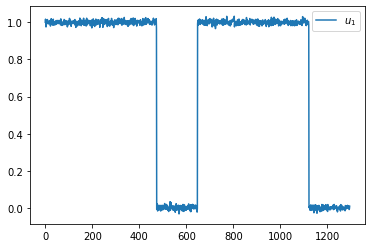

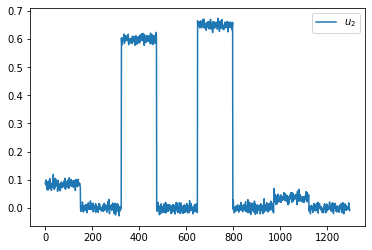

NameError: name 'outputs' is not defined

In [ ]:
%matplotlib inline
for i in range(inputs.shape[2]):
    plt.plot(inputs[:, 0, i].detach().cpu().numpy(), label=rf"$u_{i + 1}$")
    plt.legend()
    plt.show()
    plt.close()
for i in range(outputs.shape[2]):
    plt.plot(outputs[:, 0, i].detach().cpu().numpy(), label=rf"$u_{i + 1}$")
    plt.plot(
        target_outputs[:, 0, i].detach().cpu().numpy(), label=rf"$u^{{target}}_{i + 1}$"
    )
    plt.legend()
    plt.show()
    plt.close()

plt.plot(
    outputs[:, 0, -2].detach().cpu().numpy() - outputs[:, 0, -1].detach().cpu().numpy(),
    label=rf"$u_2 - u_3$",
)
plt.plot(target_outputs[:, 0, -2].detach().cpu().numpy(), label=rf"$u^{{target}}_{2}$")
plt.plot(target_outputs[:, 0, -1].detach().cpu().numpy(), label=rf"$u^{{target}}_{3}$")
plt.legend()
plt.show()
plt.close()

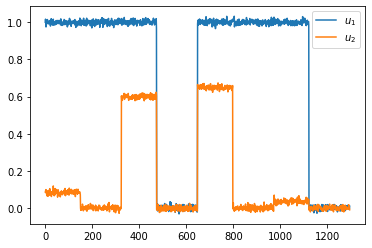

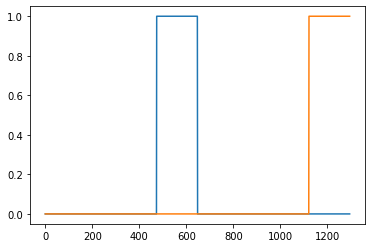

In [ ]:
%matplotlib inline
for i in range(inputs.shape[2]):
    plt.plot(inputs[:, 0, i].detach().cpu().numpy(), label=rf"$u_{i + 1}$")

plt.legend()
plt.show()
plt.close()
plt.plot(target_outputs[:, 0, 1].detach().cpu().numpy(), label=rf"$y_{2}$")
plt.plot(target_outputs[:, 0, 2].detach().cpu().numpy(), label=rf"$y_{3}$")

In [ ]:
weights_post_l = []
with torch.no_grad():
    for name, param in model.named_parameters():
        if param.requires_grad:
            weights_post_l.append((param).cpu().numpy())

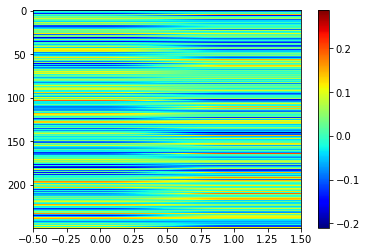

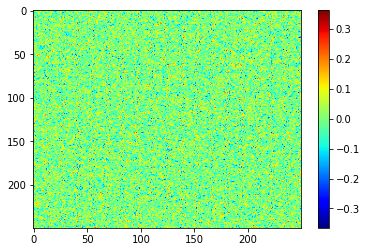

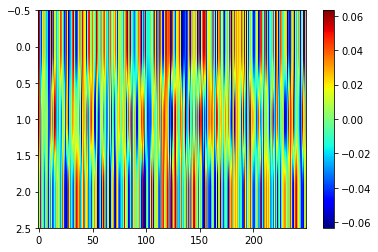

In [ ]:
%matplotlib inline
for i in range(len(weights_pre_l) - 1):
    plt.imshow((weights_pre_l[i]), aspect="auto", cmap="jet")
    plt.colorbar()
    plt.show()

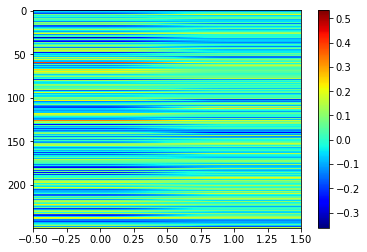

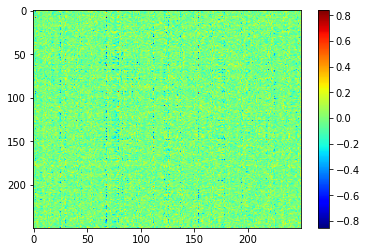

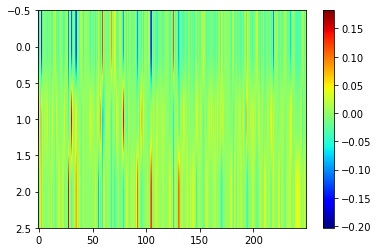

In [ ]:
%matplotlib inline
for i in range(len(weights_pre_l) - 1):
    plt.imshow(
        (weights_post_l[i]),
        aspect="auto",
        cmap="jet",
    )
    plt.colorbar()
    plt.show()

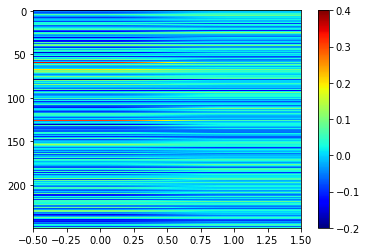

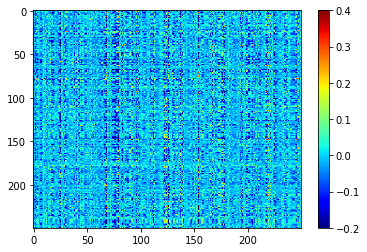

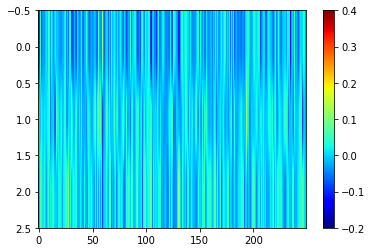

In [ ]:
%matplotlib inline
for i in range(len(weights_pre_l) - 1):
    plt.imshow(
        (weights_post_l[i] - weights_pre_l[i]),
        aspect="auto",
        cmap="jet",
        vmin=-0.2,
        vmax=0.4,
    )
    plt.colorbar()
    plt.show()